In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/HistoricalQuotes.csv')

In [3]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [4]:
print(data.columns.tolist())

['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']


In [5]:
data[' Close/Last'] = data[' Close/Last'].replace('[\$,]', '', regex=True).astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[[' Close/Last']])

In [6]:
scaled_data_df = pd.DataFrame(scaled_data, columns=[' Close/Last'])

In [7]:
train_data, test_data = train_test_split(scaled_data_df, test_size=0.2, shuffle=False)

print("Training data:")
print(train_data.head())
print("\nTesting data:")
print(test_data.head())

Training data:
   Close/Last
0    0.818943
1    0.819481
2    0.883813
3    0.868444
4    0.902409

Testing data:
      Close/Last
2014    0.152247
2015    0.150638
2016    0.147746
2017    0.146136
2018    0.147006


In [8]:
train_data = train_data.values
test_data = test_data.values

In [9]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print("Training sequences shape:", X_train.shape, y_train.shape)
print("Testing sequences shape:", X_test.shape, y_test.shape)

Training sequences shape: (1954, 60) (1954,)
Testing sequences shape: (444, 60) (444,)


In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4790e-05 - val_loss: 2.5600e-05
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0999e-05 - val_loss: 3.7324e-05
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.7823e-05 - val_loss: 4.1038e-05
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.8835e-05 - val_loss: 1.3880e-05
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4151e-05 - val_loss: 1.2345e-05
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7717e-05 - val_loss: 4.3112e-05
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.8504e-05 - val_loss: 1.5365e-05
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.5581e-05 - val_loss: 1.4038e-05
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.9158e-05 - val_loss: 1.1273e-05
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.8775e-05 - val_loss: 1.5917e-05
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8439e-0

In [15]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


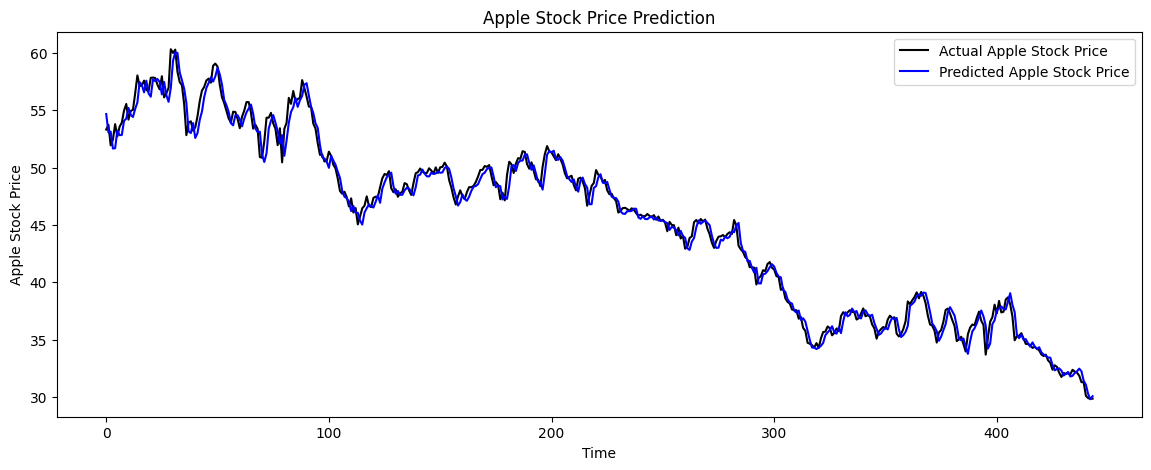

In [16]:
plt.figure(figsize=(14,5))
plt.plot(actual_prices, color='black', label='Actual Apple Stock Price')
plt.plot(predicted_prices, color='blue', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [18]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.6121552895485819
Root Mean Squared Error: 0.8145229334659421


The Mean Absolute Error of 0.6121 indicates that, on average, predictions are off by about 0.61 units from actual values. The Root Mean Squared Error of 0.8145 shows slightly larger deviations, giving more weight to larger errors. Lower MAE and RMSE values generally indicate a more accurate model.